# Project 2: 2-node Network Data

Instructions:
Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

(1) Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

(2) What can you infer about each of the distinct groups?

## Data

ROSENFELD,WHITE--ST. LOUIS CRIME
DATASETS CRIME SEX

DESCRIPTION One 870×557 two mode valued matrix of individuals by involvement in crime events. One 870×1 vector displaying the sex of each individual.

CRIME two mode, valued
SEX vector reporting sex of each individual.
BACKGROUND In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual.

Link: http://moreno.ss.uci.edu/data.html#crime

## Packages used

In [121]:
import requests
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
import operator
from scipy.stats import ttest_ind

## Functions for Parsing Data

In [122]:
def extract_string(string:str) -> str:
    '''
    input: string
    output: string
    function cleans up string
    '''
    return string.replace('\r', '').replace('"','')

def extract_int(string:str) -> int:
    '''
    input: string
    output: integer
    function cleans up string, transforms to integer
    '''
    return int(string.replace('\r', '').replace('"','').strip())

## Call Sex Data and Produce Data Frame

In [123]:
#Extract sex data from UCI website
response = requests.get('http://moreno.ss.uci.edu/sex.dat')
data = response.text 
data_by_line = data.split('\n')

#create list of names
#first name: "AbelDennis" first
#last name: RunyonMatt
name_list = []
for name in data_by_line[4:875]:
    name_list.append(extract_string(name))

#create list of sex    
sex_list = []
for sex in data_by_line[878:-1]:
    sex_list.append(extract_int(sex))

#create dataframe concatenating informaiton
sex_df = pd.DataFrame({'name': name_list, 'sex': sex_list})
sex_df

,name,sex
0,AbelDennis,1
1,AbramsChad,1
2,AbramsDavid,1
3,AbramsDon,1
4,AbramsRichard,1
...,...,...
866,YatesAugust,1
867,YorkBrant,1
868,ParkerPete,1
869,DandyCarol,0


## Call Crime Data and Produce Data Frame 

In [124]:
response = requests.get('http://moreno.ss.uci.edu/crime.dat')
data = response.text 
data_by_line = data.split('\n')
#  870

# #first name: "AbelDennis" first
# #last name: RunyonMatt
row_idx_name_2 = []
for i in data_by_line[4:874]:
    row_idx_name_2.append(extract_string(i))


# #first column: 920001
# #last column: 970556
column_headers_list = []
for i in data_by_line[875:1432]:
    column_headers_list.append(extract_int(i))

#crime data
crime_data_list = []
for crime in data_by_line[1433:-1]:
    crime_string = extract_string(crime)
    #split string and convert to list of integers
    crime_list = []
    for i in crime_string.split():
        crime_list.append(i)    
    crime_data_list.append(crime_list)

crime_data_list

#unique identifier
unique_id_df = pd.DataFrame(list(range(0,len(sex_df['name']))))

# Create the pandas DataFrame  
crime_df = pd.DataFrame(crime_data_list, columns = column_headers_list) 
crime_df.insert(0,'name',row_idx_name_2)
crime_df.insert(0,'node',unique_id_df)
crime_df

,node,name,920001,930002,930003,930004,930005,930006,930007,930008,...,970547,970548,970549,970550,970551,970552,970553,970554,970555,970556
0,0,AbelDennis,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,AbramsChad,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,AbramsDavid,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,AbramsDon,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,AbramsRichard,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,865,YatesAugust,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
866,866,YorkBrant,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,867,ParkerPete,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,868,DandyCarol,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Link Sex and Crime Data

In [125]:
crime_sex_df = pd.merge(sex_df, crime_df, on='name')
crime_sex_df

,name,sex,node,920001,930002,930003,930004,930005,930006,930007,...,970547,970548,970549,970550,970551,970552,970553,970554,970555,970556
0,AbelDennis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AbramsChad,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AbramsDavid,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AbramsDon,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AbramsRichard,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,YatesAugust,1,865,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,YorkBrant,1,866,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,ParkerPete,1,867,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,DandyCarol,0,868,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Send data to csv

In [126]:
##Send Data to csv
crime_sex_df.to_csv('crime_sex_data.csv', header=True, index=False)

## Ensure CSV File is created properly.

In [127]:
crime_data_df = pd.read_csv('crime_sex_data.csv')

#convert females to 2 for next part 
crime_data_df.loc[crime_data_df['sex'] == 0, 'sex'] = 2
crime_data_df

,name,sex,node,920001,930002,930003,930004,930005,930006,930007,...,970547,970548,970549,970550,970551,970552,970553,970554,970555,970556
0,AbelDennis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AbramsChad,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AbramsDavid,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AbramsDon,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AbramsRichard,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,YatesAugust,1,865,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,YorkBrant,1,866,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,ParkerPete,1,867,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,DandyCarol,2,868,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create Node-Edge List (node, sex, relationship, incident)
Males coded as 1, Females coded as 2

In [128]:
#Create list of all the incidents
incident_list = list(crime_data_df.columns.values)

#remove uncessary names and bad data
incident_list.remove('name')
incident_list.remove('sex')
incident_list.remove('node')
incident_list.remove('960267.1')
incident_list.remove('960247.1')
incident_list.remove('950203')

# #initialize empty array for node edge pairs
bipart_data_structure = []

for incident in incident_list:

    #create data frame with just node, sex, and incident
    incident_df = crime_data_df[['node','sex', incident]]

    #extract rows with values greater than 0
    incident_compressed_df = incident_df[(incident_df > 0).all(axis=1)]

    #create a list from the data frame
    incident_compressed_list = incident_compressed_df.values.tolist()

    for person in incident_compressed_list:
        person.append(incident)
        bipart_data_structure.append(person)

bipart_data_structure
bipart_data_structure_df = pd.DataFrame(bipart_data_structure, columns = ['node', 'sex', 'relationship', 'incident'])   
bipart_data_structure_df

,node,sex,relationship,incident
0,111,1,1,920001
1,442,2,3,930002
2,443,2,3,930002
3,444,2,3,930002
4,614,1,1,930002
...,...,...,...,...
1476,55,1,2,970556
1477,56,1,2,970556
1478,446,1,2,970556
1479,469,1,2,970556


## Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.

In [129]:
#bring in the data name
crime_data_df
bipart_data_structure_df
bipart_data_df = pd.merge(bipart_data_structure_df, crime_data_df, on='node')
bipart_data_df = bipart_data_df[['name','node','sex_x','relationship','incident']]
bipart_data_df.to_csv('bipart_crime_data.csv')
bipart_data_df

,name,node,sex_x,relationship,incident
0,BrowningCalder,111,1,1,920001
1,BrowningCalder,111,1,1,930014
2,BrowningCalder,111,1,1,930020
3,BrowningCalder,111,1,1,960369
4,BrowningCalder,111,1,1,960386
...,...,...,...,...,...
1476,FieldsWalter,272,1,1,970548
1477,DeaconHubert,219,1,2,970553
1478,LaddClarence,473,1,4,970554
1479,BenderCarlos,55,1,2,970556


## Review of Data

In [130]:
#organize data
bipart_data_df.groupby(['name','relationship'], as_index=False)['incident'].count()
df2 = bipart_data_df.groupby(['name'], as_index=False)['incident'].count()
df2.sort_values(by=['incident'], ascending=False)

#possible domestic incident, (victims female???)
#top guy, a trouble maker, Wilson Mac
bipart_data_df[bipart_data_df['name']=='WilsonMac']

bipart_data_df[bipart_data_df['incident']=='960307']
wilsons_incidents = list(bipart_data_df[bipart_data_df['name']=='WilsonMac']['incident'])
bipart_data_df[bipart_data_df['incident'].isin(wilsons_incidents)].sort_values(by=['incident'], ascending=False)

#top five people and make graphs.  


,name,node,sex_x,relationship,incident
1063,WilsonMac,854,1,2,970550
471,CusackJill,208,2,1,970550
1171,JohnsonJack,432,1,1,970526
1062,WilsonMac,854,1,2,970526
1061,WilsonMac,854,1,2,970521
1003,WilliamsRoosevelt,848,1,2,970521
1443,BrownLeonard,108,1,1,970521
779,SmithAnthony,725,1,2,970521
1038,SaxeGina,697,2,1,970495
1060,WilsonMac,854,1,2,970495


In [131]:
#extract males from the dataset 
males = bipart_data_df['sex_x']==1
bipart_data_males_df = bipart_data_df[bipart_data_df['sex_x']==1]

# number of unique events that males are in 
bipart_data_males_df['incident'].nunique()
#males are in 491 events


491

## Prep and Import data into Networkx Graph

In [132]:
#Prepare edge data
edges = pd.read_csv('bipart_crime_data.csv')
edges['weight'] = 1
edges = edges[['name','sex_x','relationship','incident','weight']]
edges = edges.rename(columns={'name': 'source', 'sex_x':'source_sex', 'incident':'target', 'relationship':'value'})

In [133]:
#create graph and add edges
g = nx.from_pandas_edgelist(edges, edge_attr=True)

In [134]:
# for person, incident, edge_data in g.edges(data=True):
#     print(person, incident, edge_data)

## Initial Graph Shows Clusters of Activity

This is perhaps and indidication of some sort of organize crime

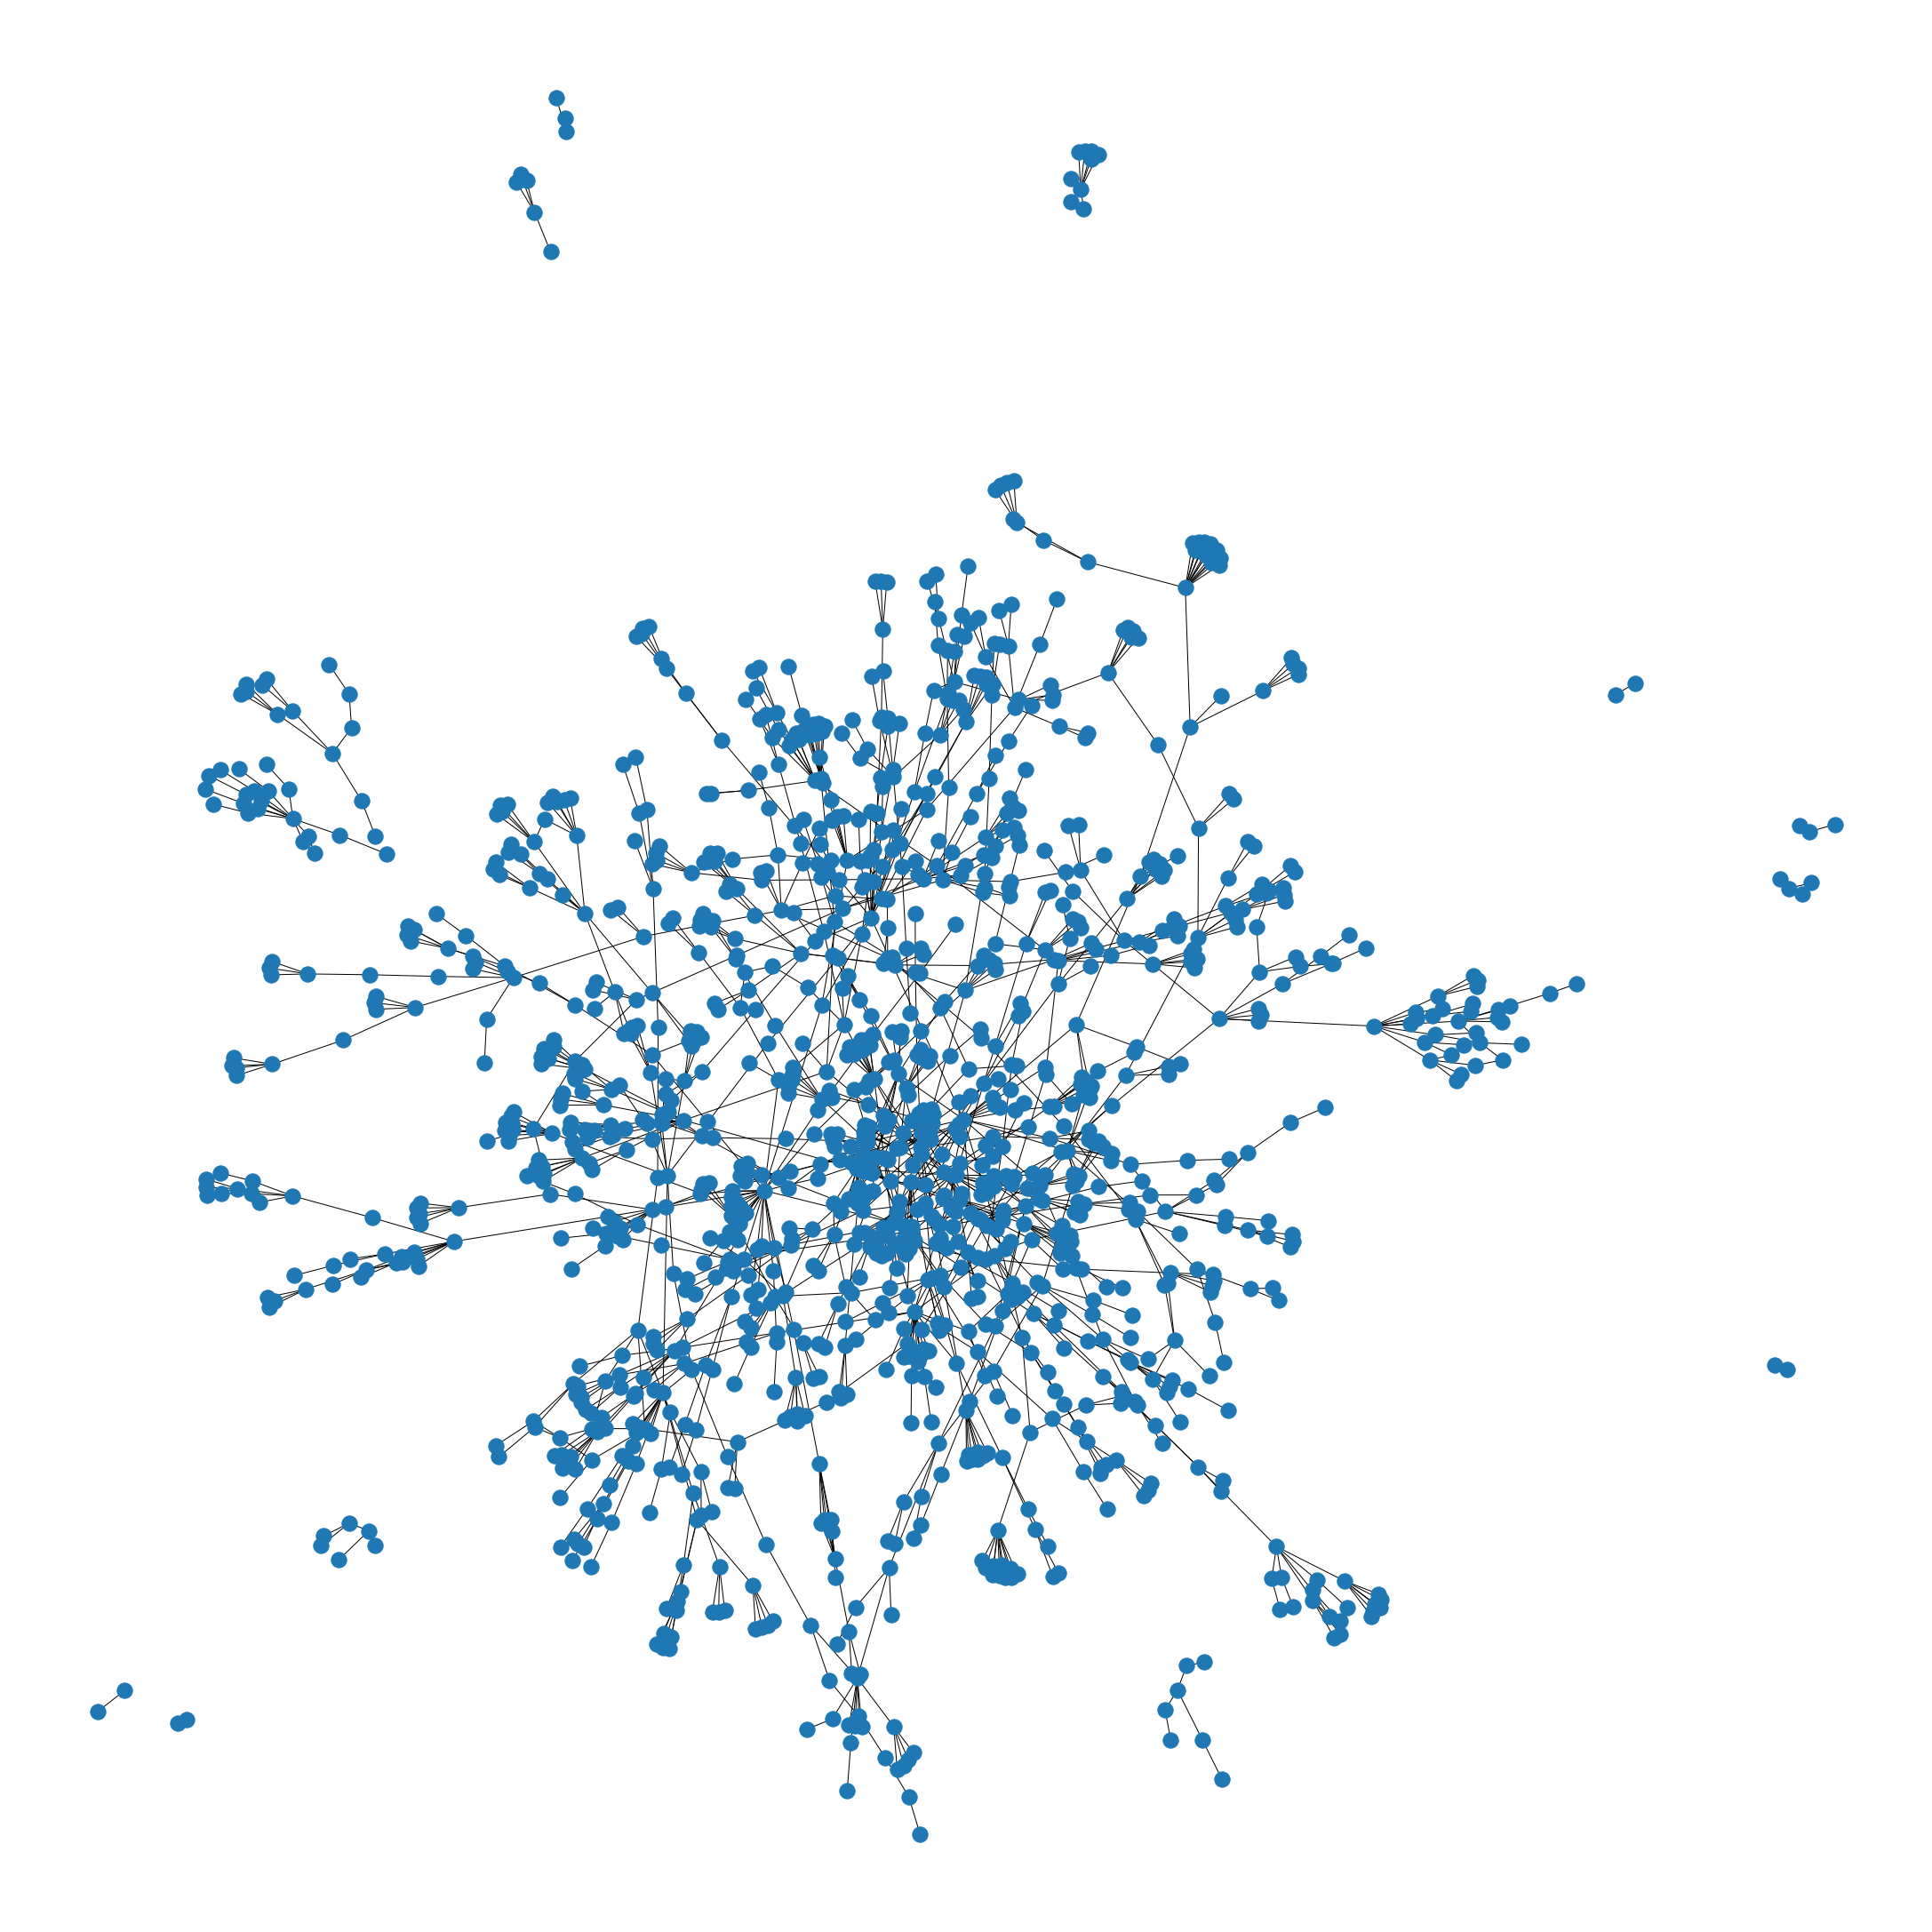

In [135]:
#Generate graph
plt.figure(figsize=(30,30))  
nx.draw(g)
#too dense, may have to use snowball sampling 

## Calculation of Weights and Island Method Functions

Island methods splits up the giant component into smaller components, and the subcomponents are individually analyzed.  We will use this method to extract areas with the strongest amount of crime activity.  To employ the island method, we used used the Newman Method discussed in the Tore Opsahl's "Projection" paper with discussed weighted two-node networks for co-occurences.  We used thes ame method discussed in the paper which described co-collaborators on a published paper.  We applied this same logic to applying weights to for parties involved in the same incident.  

In [136]:
def calculate_weight(num_people_in_incident:list) -> float:
    '''
    Newman (2001) Method from Tore Opsahl's "Projection", Weighted Two-Node Networks for Co-occurence
    https://toreopsahl.com/tnet/two-mode-networks/projection/
    input: List of People in the Incident
    output: weight calculated by number of people in the incident.
    '''
    weight = 0.0
    
    num_people_in_incident = len(persons_in_incident_list)
    
    if num_people_in_incident > 2:
        weight = 1.0/(num_people_in_incident-1)
    elif num_people_in_incident == 2:
        weight = 1.0
    else: 
        weight = 0.0
        
    return(weight)

#create a list of all distinct incidents
incidents_list = list(set(bipart_data_df['incident']))
# #transform that list of sets into a list of lists 
incident_pairs_list = [list(combo) for combo in incidents_list] 

#create a list of co-oc 
co_occurence_list = []
#STEP ONE: loop throught all events
for incident in incidents_list:
    #STEP TWO: create a list of all individuals involved in the indivdiual event incident
    persons_in_incident_list = list(bipart_data_df[(bipart_data_df.incident == incident)]['name'])
    #STEP THREE: Create a combinations of all Iindividuals listed in that event
    for pair in [list(combo) for combo in itertools.combinations(persons_in_incident_list, 2)]:
        co_occurence_list.append(pair)

        
#append 0 to all pairs
for pairs in co_occurence_list:
    pairs.append(0)

    
#STEP ONE: loop through Incident List
for incident in incidents_list:
    #STEP TWO: Create a list of individuals involved in the incident
    persons_in_incident_list = list(bipart_data_df[(bipart_data_df.incident == incident)]['name'])
    
    #STEP THREE: Loop through the combination of pairs
    for pair_id, pairs in enumerate(co_occurence_list):
        person_one = pairs[0]
        person_two = pairs[1]
        
        #STEP FOUR: If both individuals appear int he list, calculate the weight
        if all(x in persons_in_incident_list for x in [person_one, person_two]):
        
            #calculate the weight
            weight = calculate_weight(persons_in_incident_list)
            #add the weight to the current running total
            co_occurence_list[pair_id][2] += weight

#create Pandas DataFrame and csv file
co_occurence_df = pd.DataFrame(co_occurence_list)
#rename columns
co_occurence_df.columns = ['node', 'edge','weight']
#send dataframe to csv 
co_occurence_df.to_csv('co_occurence_weights.csv', header=True, index=False)

## Pull Data from csv and Add Sex 

In [137]:
#pull data from csv to add sex
co_occurence_df = pd.read_csv('co_occurence_weights.csv')
co_occurence_df.columns = ['name', 'edge','weight']
co_occurence_df2 = pd.merge(co_occurence_df, sex_df, on='name', how='left')
co_occurence_df2.columns = ['node', 'name','weight','node_sex']
co_occurence_df3 = pd.merge(co_occurence_df2, sex_df, on='name', how='left')
co_occurence_df3.columns = ['node', 'name','weight','node_sex', 'edge_sex']
co_occurence_df3
# co_occurence_df3.to_csv('co_occurence_weights_sex.csv', header=True, index=False)


,node,name,weight,node_sex,edge_sex
0,CarverJustin,CurtisMyles,0.333333,1,1
1,CarverJustin,ManettaMarshall,0.333333,1,1
2,CarverJustin,MullinsMarv,0.333333,1,1
3,CurtisMyles,ManettaMarshall,0.333333,1,1
4,CurtisMyles,MullinsMarv,0.333333,1,1
...,...,...,...,...,...
2352,GliddenHoppy,RitterBobby,0.333333,1,1
2353,GodfreyTalia,RitterBobby,0.333333,0,1
2354,SimpsonBart,SimpsonAdella,0.833333,1,0
2355,SimpsonBart,ThompsonBert,0.500000,1,1


## Revie Edge Data with Weights

In [138]:
#Prepare edge data
edges_co_df = pd.read_csv('co_occurence_weights_sex.csv')
edges_co_df.columns = ['source', 'target', 'weight', 'source_sex', 'target_sex']
edges_co_df

,source,target,weight,source_sex,target_sex
0,BendixJerryLee,JohnstonJustin,1.250000,1,1
1,JonesHarris,McConnellPhyllis,0.333333,1,0
2,JonesHarris,FlowersSteve,0.333333,1,1
3,JonesHarris,StevensonMike,0.333333,1,1
4,McConnellPhyllis,FlowersSteve,0.333333,0,1
...,...,...,...,...,...
2352,BarretScott,LowellConrad,0.333333,1,1
2353,GliddenStan,LowellConrad,0.333333,1,1
2354,DerbyTammy,DerbyNeil,1.000000,0,1
2355,SwiftMaurice,DeaconHubert,1.000000,1,1


# Load Data into NetworkX

In [139]:
#create graph and add edges
gc = nx.from_pandas_edgelist(edges_co_df, edge_attr=True)

## Generate Graph of All Data

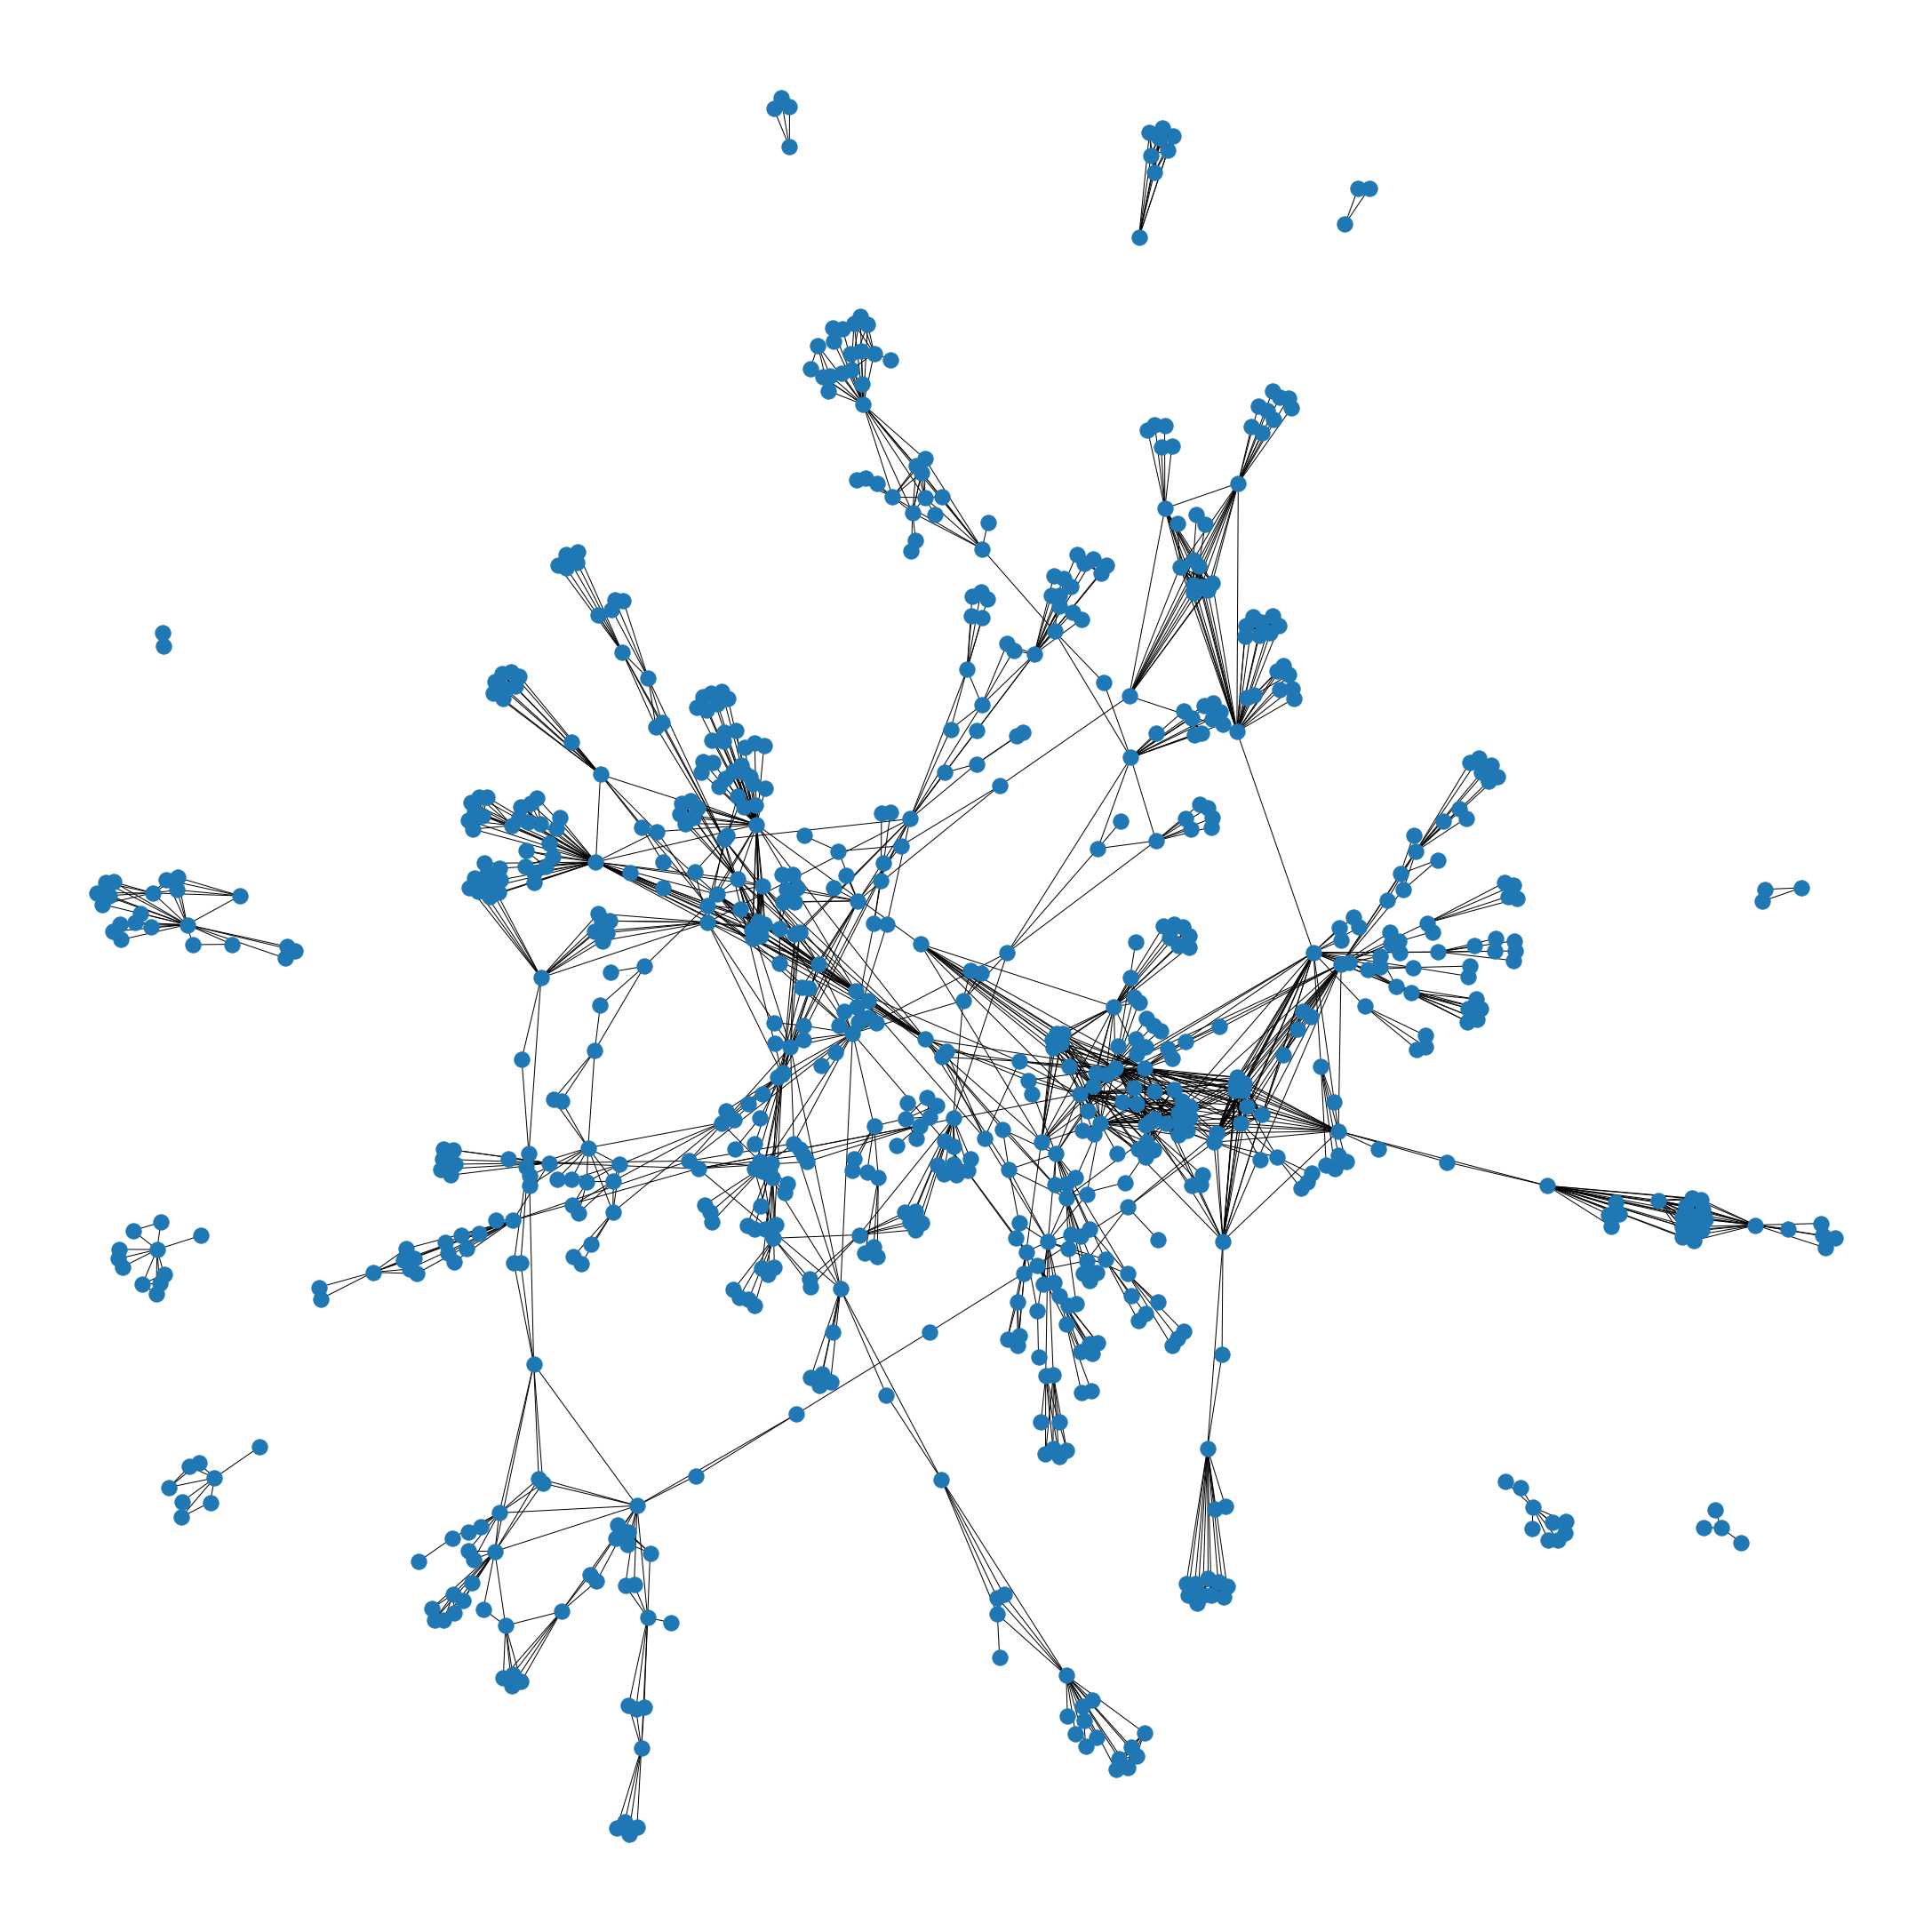

In [140]:
#Generate graph
plt.figure(figsize=(30,30))  
nx.draw(gc)
# nx.draw(gc, with_labels=1, font_size=28)
#too dense, may have to use snowball sampling 

# Island Method Functions 

Below are the functions used in employing the Island method.  We used the code referenced in Chapter 4 of Social Network Analysis.  This code is tailored for low weight situations.  

In [141]:
#trim edges function
def trim_edges(graph: object, threshold=1.0) -> object:
    '''
    Input: Graph and Weight Threshold
    Output: Modified graph object 
    trim_edges fncn takes a graph and filters the weight, i.e., "water level"
    All edges above a specified threshold are retained.  
    '''
    node_edge_list = []
    for node, edge, edge_data in graph.edges(data=True):
        if edge_data['weight'] > threshold:
            x = [node, edge, edge_data['weight'], edge_data['source_sex'], edge_data['target_sex']]
            node_edge_list.append(x)
    node_edge_list_df = pd.DataFrame(node_edge_list)
    node_edge_list_df.columns = ['source', 'target', 'weight', 'source_sex', 'target_sex']
    g2 = nx.from_pandas_edgelist(node_edge_list_df, edge_attr=True)
    return g2

#island method function, uses trim edges
def island_method(graph: object, iterations=5) -> list:
    '''
    Input: Graph Object
    Output: List of sub graphs and the size.  
    Application of the island method.      
    '''

    #create a list of weights from the specificed graph
    weights = [edata['weight'] for node, edge, edata in graph.edges(data=True)]
    
    #mininum threshold set to 0.501, mainly to remove (1) single incidence of occurences or (2) weak connections
    mn = min(weights)
    
    if mn < 0.501:
        mn = 0.501
    else:
        mn = mn
    
    #maximum
    mx = max(weights)
    
    #compute the size of the step, so we get a reasonable step in iterations
    step = (mx-mn)/iterations

    return [[threshold, trim_edges(graph, threshold)] for threshold in np.arange(mn,mx,step)]

def connected_component_subgraphs(graph: object) -> object:
    for c in nx.connected_components(graph):
        yield g.subgraph(c)

## Trim Weights to Generate SubGraphs

From this graph we can see that there are many dyads, triads, etc.

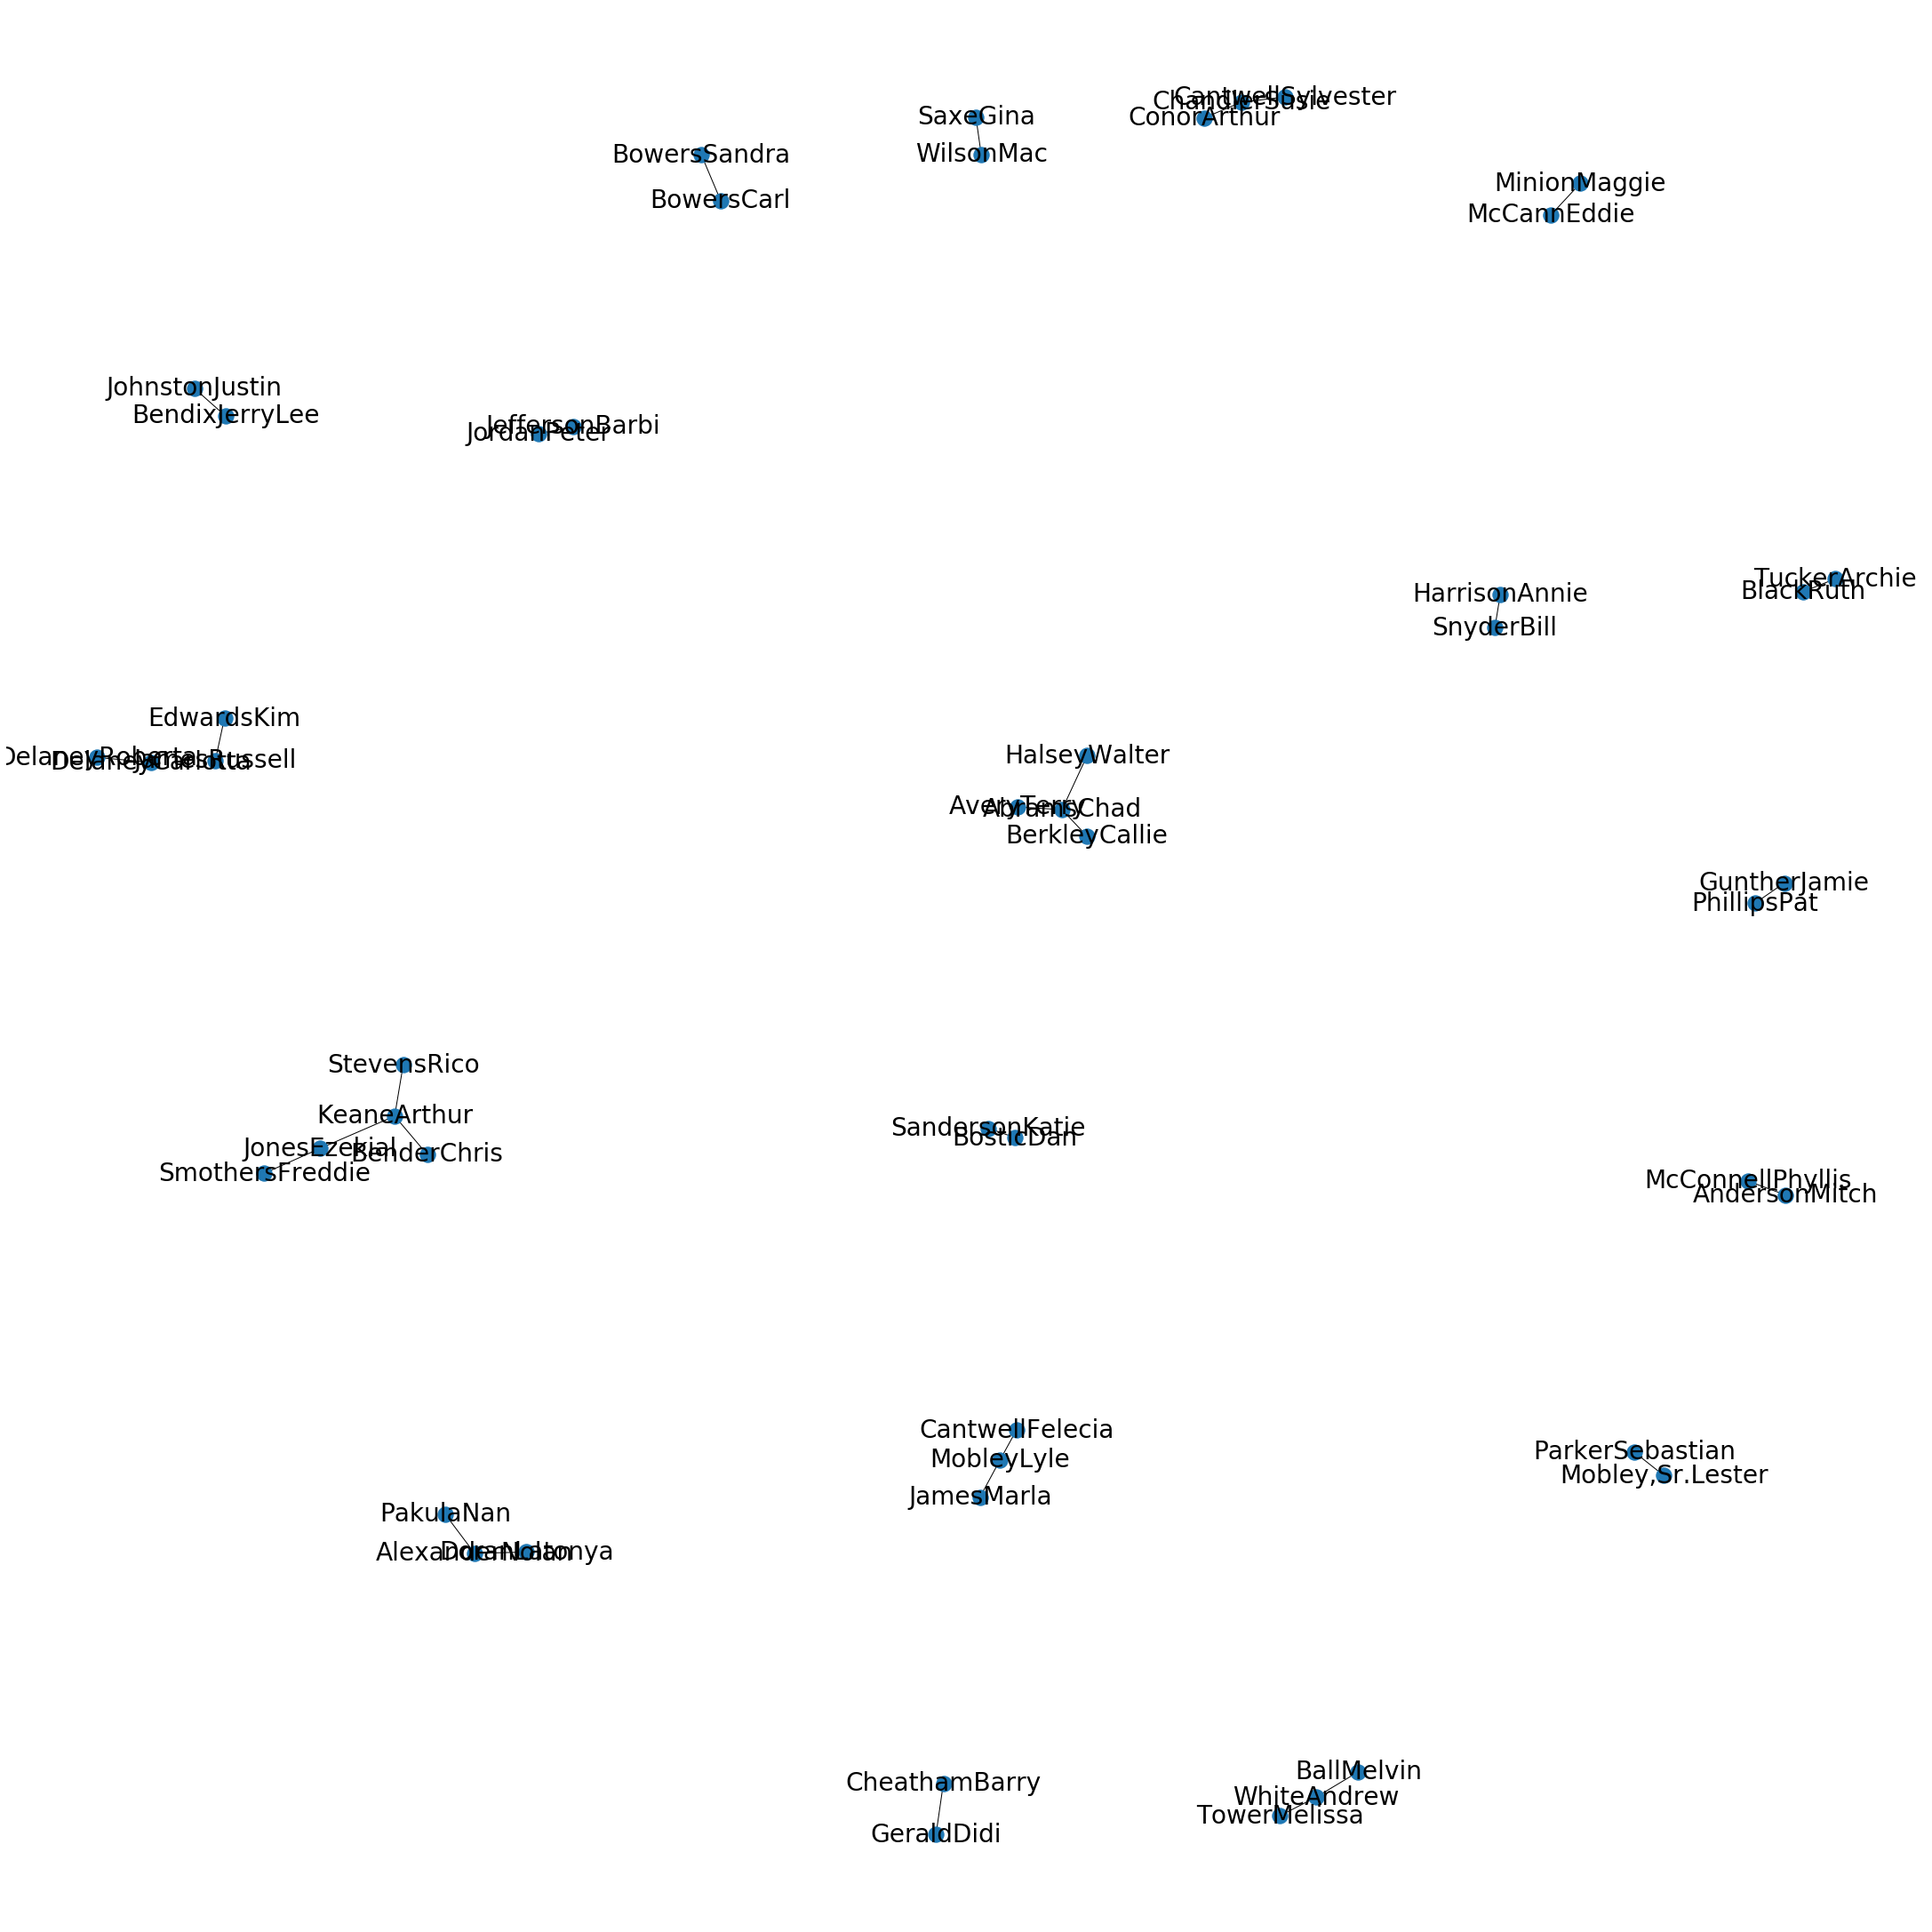

In [142]:
sub_graphs = trim_edges(gc)
plt.figure(figsize=(30,30)) 
nx.draw(sub_graphs, with_labels=1, font_size=28)

# Application of the Island Method

After we remove all of the links with a weight of 0.501, the network breaks out into 56 island subgraphs, which all represent a group of people who are linked via incidences.  These graphs would include a significant amount of individuals who are connected via a few incidences or a siginificant amount of people are connected to those incidences.  

There are at least 10 graphs where individuals are conistently connected.  This could possibly indicate some type of organized crime or individuals who are repeatedly involved in the same type of incident.  

In [144]:
cc = list(gc.subgraph(c) for c in sorted(nx.connected_components(gc), key=len, reverse=True))[0]
islands=island_method(cc,5)
for i in islands:
    print(i[0], len(i[1]), 
          len(list(i[1].subgraph(c) for c in sorted(nx.connected_components(i[1]), key=len, reverse=True))))

0.501 244 56
1.3008000000000002 38 17
2.1006000000000005 14 7
2.9004000000000003 10 5
3.7002000000000006 4 2


## A Review of the Top Five Connections

The top five connections are all male-female pairs.  

In [145]:
subgraph = trim_edges(gc,2.9)
for node, edge, edge_data in subgraph.edges(data=True):
    print(node, edge, edge_data)

McConnellPhyllis AndersonMitch {'weight': 3.1428571428571432, 'source_sex': 0, 'target_sex': 1}
CantwellFelecia MobleyLyle {'weight': 3.5588235294117645, 'source_sex': 0, 'target_sex': 1}
SandersonKatie BosticDan {'weight': 4.0, 'source_sex': 0, 'target_sex': 1}
AbramsChad BerkleyCallie {'weight': 3.5, 'source_sex': 1, 'target_sex': 0}
TuckerArchie BlackRuth {'weight': 4.5, 'source_sex': 0, 'target_sex': 1}


BlackRuth and TuckerArchie have the strongest connection.  Unfortunately it looks like BlackRuth (female) is typically the victim in the incidents and TuckerArchie (male) is the suspect in all six of these events.  

In [146]:
#extract all events with TuckerArchie and BlackRuth.  They are actually all the same.  Strong connection.
bipart_data_df[(bipart_data_df.name =='TuckerArchie') | (bipart_data_df.name =='BlackRuth')]

,name,node,sex_x,relationship,incident
354,BlackRuth,81,2,1,930054
355,BlackRuth,81,2,1,950157
356,BlackRuth,81,2,1,950198
357,BlackRuth,81,2,1,960375
358,BlackRuth,81,2,1,970492
359,BlackRuth,81,2,1,970515
361,TuckerArchie,803,1,2,930054
362,TuckerArchie,803,1,2,950157
363,TuckerArchie,803,1,2,950195
364,TuckerArchie,803,1,2,950198


In [147]:
#select all events
events = list(set(bipart_data_df[(bipart_data_df.name =='TuckerArchie') | (bipart_data_df.name =='BlackRuth')]['incident']))
bipart_data_df[bipart_data_df['incident'].isin(events)]

,name,node,sex_x,relationship,incident
354,BlackRuth,81,2,1,930054
355,BlackRuth,81,2,1,950157
356,BlackRuth,81,2,1,950198
357,BlackRuth,81,2,1,960375
358,BlackRuth,81,2,1,970492
359,BlackRuth,81,2,1,970515
360,CarterRuby,151,2,3,930054
361,TuckerArchie,803,1,2,930054
362,TuckerArchie,803,1,2,950157
363,TuckerArchie,803,1,2,950195


Here we see that we have a troublemaker, AbramsChad.  AbramsChad is the the primarily the suspect in approximately 20 difference incidences.  AbramsChad is typically the suspect and BerkleyCallie is generally the victim, in the co-occuring event.  

In [148]:
#extract all events with AbramsChad and BerkleyCallie.  They are actually all the same.  Strong connection.
bipart_data_df[(bipart_data_df.name =='AbramsChad') | (bipart_data_df.name =='BerkleyCallie')]

,name,node,sex_x,relationship,incident
190,AbramsChad,1,1,1,930029
191,AbramsChad,1,1,2,940121
192,AbramsChad,1,1,1,940126
193,AbramsChad,1,1,2,940146
194,AbramsChad,1,1,2,950159
195,AbramsChad,1,1,2,950163
196,AbramsChad,1,1,2,950174
197,AbramsChad,1,1,2,950177
198,AbramsChad,1,1,2,950182
199,AbramsChad,1,1,3,950202


In [149]:
#select all events
events = list(set(bipart_data_df[(bipart_data_df.name =='AbramsChad') | (bipart_data_df.name =='BerkleyCallie')]['incident']))
bipart_data_df[bipart_data_df['incident'].isin(events)]

,name,node,sex_x,relationship,incident
190,AbramsChad,1,1,1,930029
191,AbramsChad,1,1,2,940121
192,AbramsChad,1,1,1,940126
193,AbramsChad,1,1,2,940146
194,AbramsChad,1,1,2,950159
...,...,...,...,...,...
1305,JayLucinda,421,2,3,970414
1306,VincennesDaisy,817,2,3,970414
1471,GodfreyBrian,315,1,2,970546
1472,MitchellGabrielle,556,2,2,970546


SandersonKatie (female) has been the the victim in many incidents.  BosticDan is a repeated suspect.  Interestinly, it looks like SandersonKatie may have gotten into some type of dispute with three male family members: LangdonAndrew, LangdonCharles, and LangdonDerrick. 

In [150]:
#extract all events with SandersonKatie and BosticDan.  They are actually all the same.  Strong connection.
bipart_data_df[(bipart_data_df.name =='SandersonKatie') | (bipart_data_df.name =='BosticDan')]

,name,node,sex_x,relationship,incident
129,SandersonKatie,693,2,1,930013
130,SandersonKatie,693,2,1,930036
131,SandersonKatie,693,2,1,930065
132,SandersonKatie,693,2,1,940127
133,SandersonKatie,693,2,1,940138
134,SandersonKatie,693,2,1,940144
135,SandersonKatie,693,2,3,960286
136,SandersonKatie,693,2,1,960335
137,SandersonKatie,693,2,1,970455
658,BosticDan,90,1,2,940127


In [151]:
#select all events
events = list(set(bipart_data_df[(bipart_data_df.name =='SandersonKatie') | (bipart_data_df.name =='BosticDan')]['incident']))
bipart_data_df[bipart_data_df['incident'].isin(events)]

,name,node,sex_x,relationship,incident
126,DouglasCollin,237,1,1,930013
127,GreenByron,333,1,1,930013
128,PowellGeorge,645,1,1,930013
129,SandersonKatie,693,2,1,930013
130,SandersonKatie,693,2,1,930036
131,SandersonKatie,693,2,1,930065
132,SandersonKatie,693,2,1,940127
133,SandersonKatie,693,2,1,940138
134,SandersonKatie,693,2,1,940144
135,SandersonKatie,693,2,3,960286


# Calculating the Degree and Eigenvector Degree of Centrality

The purpose of calculating the degree of centrality and the eigenvector degree of centrality is to determine a possible source, as the original data discussion indicated that the dataset was created from reviewing a single case file and then finding connections with subsequent incidences.  

### Alter the weight to 1

In [152]:
#Create edges for centrality 
edges_centrality_df = edges_co_df
#reset all weights to 1
edges_centrality_df['weight'] = 1
edges_centrality_df

,source,target,weight,source_sex,target_sex
0,BendixJerryLee,JohnstonJustin,1,1,1
1,JonesHarris,McConnellPhyllis,1,1,0
2,JonesHarris,FlowersSteve,1,1,1
3,JonesHarris,StevensonMike,1,1,1
4,McConnellPhyllis,FlowersSteve,1,0,1
...,...,...,...,...,...
2352,BarretScott,LowellConrad,1,1,1
2353,GliddenStan,LowellConrad,1,1,1
2354,DerbyTammy,DerbyNeil,1,0,1
2355,SwiftMaurice,DeaconHubert,1,1,1


### Calculate centrality graph and degree of centrality and eigenvector degree of centrality 

In [153]:
#Create graph to use of centrality 
centrality_graph = nx.from_pandas_edgelist(edges_centrality_df, edge_attr=True)

#calculate degress centrality
node_degree_centrality = nx.degree_centrality(centrality_graph)
node_degree_centrality_df = pd.DataFrame(node_degree_centrality.items())
node_degree_centrality_df.columns = ['node','degree_centrality']


#calculate eigenvector degree centrality
node_eigenvector_centrality = nx.eigenvector_centrality(centrality_graph)
node_eigenvector_centrality_df = pd.DataFrame(node_eigenvector_centrality.items())
node_eigenvector_centrality_df.columns = ['node','eigenvector_centrality']

#merge degree centrality and eigenvector centrality
centrality_df = pd.merge(node_degree_centrality_df, node_eigenvector_centrality_df, on='node')

### Degree of Centrality 

In [154]:
centrality_df.sort_values(by='degree_centrality', ascending=False).head(5)

,node,degree_centrality,eigenvector_centrality
179,KeaneArthur,0.062044,0.307693
201,AbramsChad,0.058394,0.013428
118,HemphillButch,0.053528,0.008411
153,SmothersFreddie,0.040146,0.260809
0,BendixJerryLee,0.040146,0.214882


### Eigenvector Degree of Centrality 

In [155]:
centrality_df.sort_values(by='eigenvector_centrality', ascending=False).head(5)

,node,degree_centrality,eigenvector_centrality
179,KeaneArthur,0.062044,0.307693
153,SmothersFreddie,0.040146,0.260809
41,StevensRico,0.035280,0.225446
0,BendixJerryLee,0.040146,0.214882
53,BinderErrol,0.030414,0.208865


### Another Troublemaker (Well-connected)

In [156]:
bipart_data_df[(bipart_data_df.name =='KeaneArthur')]

,name,node,sex_x,relationship,incident
715,KeaneArthur,446,1,2,940149
716,KeaneArthur,446,1,2,940150
717,KeaneArthur,446,1,1,950173
718,KeaneArthur,446,1,2,960250
719,KeaneArthur,446,1,2,960253
720,KeaneArthur,446,1,2,960265
721,KeaneArthur,446,1,2,960280
722,KeaneArthur,446,1,2,960294
723,KeaneArthur,446,1,2,960326
724,KeaneArthur,446,1,2,960331


In [157]:
centrality_sex_df = pd.merge(sex_df, centrality_df, left_on='name', right_on='node')
centrality_sex_df

,name,sex,node,degree_centrality,eigenvector_centrality
0,AbramsChad,1,AbramsChad,0.058394,1.342787e-02
1,AbramsDavid,1,AbramsDavid,0.001217,9.623849e-04
2,AbramsDon,1,AbramsDon,0.008516,1.114632e-03
3,AbramsRichard,1,AbramsRichard,0.008516,1.621440e-03
4,AdamsCurtis,1,AdamsCurtis,0.008516,2.281166e-02
...,...,...,...,...,...
818,YatesAugust,1,YatesAugust,0.002433,6.996796e-09
819,YorkBrant,1,YorkBrant,0.004866,1.188204e-04
820,ParkerPete,1,ParkerPete,0.001217,9.623849e-04
821,DandyCarol,0,DandyCarol,0.002433,1.800438e-26


In [158]:
#men being more involved in crime center of crime than females.  
#Can look at the victim rates, see if on average women are more victims or witnesses
centrality_males_df = centrality_sex_df[(centrality_sex_df.sex==1)]['degree_centrality']
centrality_females_df = centrality_sex_df[(centrality_sex_df.sex==0)]['degree_centrality']
ttest_ind(centrality_males_df, centrality_females_df)

Ttest_indResult(statistic=1.5041522321933924, pvalue=0.13292674943066532)